## Part 1: Exploring the Mountain Car Environment

In this part we set up and explore the Mountain Car environment and inspect how a simple fixed policy behaves.

There are **three code cells**:

1. **Setup** — creates the environment, defines helper functions, and sets up a simple heuristic policy.
2. **Plots** — runs the policy once and plots position, velocity, and the phase plot.
3. **Video** — records a short animation showing how the policy behaves.

Run all cells and make sure you understand what the plots show.


In [1]:
# === Setup and helper functions ===

# Install and import
#!pip install gymnasium[classic_control] --quiet

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# Create environment
env = gym.make("MountainCar-v0")

print("Observation space:", env.observation_space)
print("  low :", env.observation_space.low)
print("  high:", env.observation_space.high)
print()
print("Action space:", env.action_space)
print("Number of actions:", env.action_space.n)

# ----- Helper: run one episode with a given policy -----
def run_episode(env, policy, max_steps=200):
    """
    Run one episode using the given policy.
    policy: function that maps state -> action (integer).
    Returns: states, actions, rewards as numpy arrays.
    """
    states = []
    actions = []
    rewards = []

    state, info = env.reset()
    done = False
    steps = 0

    while not done and steps < max_steps:
        states.append(state)
        action = policy(state)
        actions.append(action)

        next_state, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)

        state = next_state
        done = terminated or truncated
        steps += 1

    return np.array(states), np.array(actions), np.array(rewards)

# ----- Policy: "greedy towards the goal" (but actually bad) -----
def greedy_towards_goal_policy(state):
    position, velocity = state
    goal_position = 0.5  # flag on the right hill

    # Naïve idea: if goal is to the right, always push right
    if position < goal_position:
        return 2  # push right
    else:
        return 0  # almost never reached in practice

# ----- Helper: plot a trajectory -----
def plot_trajectory(states, title_prefix=""):
    pos = states[:, 0]
    vel = states[:, 1]
    t = np.arange(len(pos))

    fig, axs = plt.subplots(3, 1, figsize=(8, 10))

    axs[0].plot(t, pos)
    axs[0].axhline(0.5, linestyle="--", color="tab:red")
    axs[0].set_ylabel("Position")
    axs[0].set_title(f"{title_prefix}Position over time")
    axs[0].grid(True)

    axs[1].plot(t, vel)
    axs[1].set_ylabel("Velocity")
    axs[1].set_title(f"{title_prefix}Velocity over time")
    axs[1].grid(True)

    axs[2].plot(pos, vel, marker=".")
    axs[2].set_xlabel("Position")
    axs[2].set_ylabel("Velocity")
    axs[2].set_title(f"{title_prefix}Phase plot (position vs velocity)")
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()


Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
  low : [-1.2  -0.07]
  high: [0.6  0.07]

Action space: Discrete(3)
Number of actions: 3


Greedy-towards-goal policy:
  Episode length: 200
  Total return (sum of rewards): -200.0


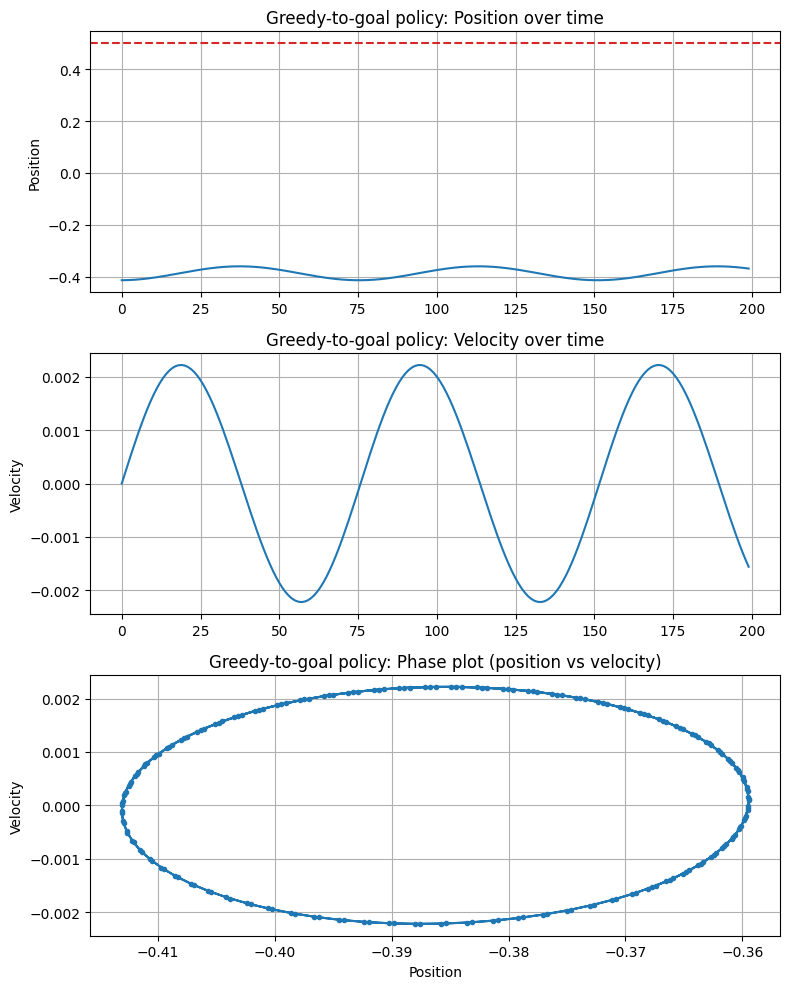

In [2]:
# === Run the naïve policy and inspect behaviour ===

states_greedy, actions_greedy, rewards_greedy = run_episode(env, greedy_towards_goal_policy)

print("Greedy-towards-goal policy:")
print("  Episode length:", len(rewards_greedy))
print("  Total return (sum of rewards):", rewards_greedy.sum())

plot_trajectory(states_greedy, title_prefix="Greedy-to-goal policy: ")


In [3]:
# === create and display a video of the failing policy ===

#!pip install imageio --quiet
import imageio
from IPython.display import Video

env_video = gym.make("MountainCar-v0", render_mode="rgb_array")

def record_policy(env, policy, filename="mountaincar_greedy_fail.mp4", max_steps=200):
    frames = []
    state, info = env.reset()
    for t in range(max_steps):
        frame = env.render()
        frames.append(frame)

        action = policy(state)
        state, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break

    imageio.mimsave(filename, frames, fps=30)
    return filename

video_path = record_policy(env_video, greedy_towards_goal_policy)
Video(video_path, embed=True)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Part 2: Linear and Polynomial Function Approximation

In this part we evaluate a fixed heuristic policy using simple feature representations.

There are **three code cells**:

1. **Policy** — defines the heuristic policy we want to evaluate.

2. **Reference Value** — computes a high-accuracy value function on a grid using brute-force Monte Carlo simulation.  
   *This is only possible here because Mountain Car has a small, two-dimensional state space **and** the simulator allows us to force the system into any state we like. In most RL problems neither of these is true: the state space is too large to grid-sample, and we cannot arbitrarily reset the environment to every possible state. For real problems, learning methods (MC/TD) are the only feasible option.*

3. **MC and TD(0)** — runs Monte Carlo and TD learning with linear and polynomial features and plots the resulting approximations.

Run all cells and compare the approximations to the reference value.




In [4]:
# ----- Policy to evaluate (good heuristic policy) -----
def good_policy(state):
  # Push in the direction of current velocity
    x, v = state
    return 2 if v >= 0 else 0   # push in direction of motion


In [5]:
# === Part 2: Linear Value Function Approximation with Reference  ===

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# ----- Environment -----
env = gym.make("MountainCar-v0")
POS_MIN, POS_MAX = env.observation_space.low[0], env.observation_space.high[0]
VEL_MIN, VEL_MAX = env.observation_space.low[1], env.observation_space.high[1]

gamma = 1.0


# ----- State normalization and features -----
def normalize_state(state):
    x, v = state
    x_n = (x - POS_MIN) / (POS_MAX - POS_MIN) * 2 - 1
    v_n = (v - VEL_MIN) / (VEL_MAX - VEL_MIN) * 2 - 1
    return x_n, v_n

def phi_raw(s):
    x_n, v_n = normalize_state(s)
    return np.array([1.0, x_n, v_n], dtype=float)

def phi_poly(s):
    x_n, v_n = normalize_state(s)
    return np.array([
        1.0,
        x_n,
        v_n,
        x_n**2,
        v_n**2,
        x_n * v_n
    ], dtype=float)

# ----- Run one episode from current env.state -----
def run_episode_from_current(env, policy):
    """Run an episode starting from env.unwrapped.state."""
    s = np.array(env.unwrapped.state, dtype=float)
    G = 0.0
    done = False
    while not done:
        a = policy(s)
        s, r, terminated, truncated, info = env.step(a)
        G += r
        done = terminated or truncated
    return G

# ----- Brute-force reference value on a grid -----
def estimate_reference(env, policy, n_x=31, n_v=31, N_MC=20):
    xs = np.linspace(POS_MIN, POS_MAX, n_x)
    vs = np.linspace(VEL_MIN, VEL_MAX, n_v)
    V = np.zeros((n_x, n_v))

    for i, x in enumerate(xs):
        for j, v in enumerate(vs):
            returns = []
            for _ in range(N_MC):
                env.reset()
                env.unwrapped.state = np.array([x, v], dtype=float)
                G = run_episode_from_current(env, policy)
                returns.append(G)
            V[i, j] = np.mean(returns)
    return xs, vs, V

print("Computing reference value function for the good policy (this may take ~20–30 seconds)...")
xs_ref, vs_ref, V_ref = estimate_reference(env, good_policy, n_x=31, n_v=31, N_MC=20)
print("Reference value function computed.")


Computing reference value function for the good policy (this may take ~20–30 seconds)...
Reference value function computed.


Training MC/TD with RAW features...
Training MC/TD with POLYNOMIAL features...

=== RMSE vs reference (good policy) ===
MC  + RAW features:        41.51
TD(0) + RAW features:      97.91
MC  + POLY features:       60.44
TD(0) + POLY features:     42.04


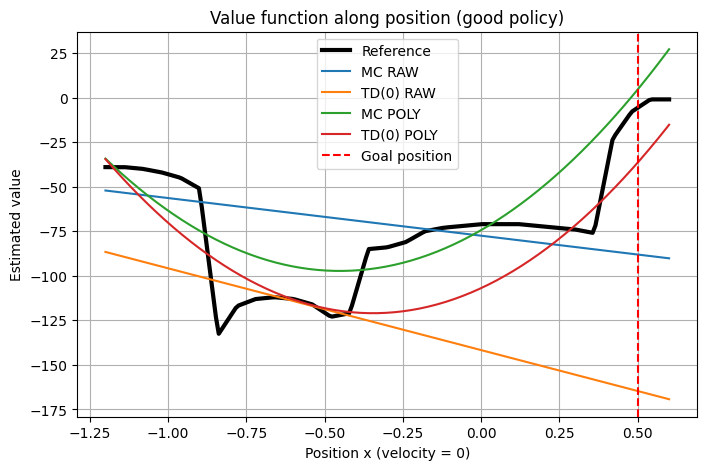

In [6]:
# === Part 2: MC and TD(0) with RAW and POLYNOMIAL features ===

# ----- Helper: run one episode with standard reset -----
def run_episode(env, policy, max_steps=200):
    states, rewards = [], []
    s, info = env.reset()
    done = False
    steps = 0
    while not done and steps < max_steps:
        states.append(s)
        a = policy(s)
        s, r, terminated, truncated, info = env.step(a)
        rewards.append(r)
        done = terminated or truncated
        steps += 1
    return np.array(states), np.array(rewards)

# ----- Monte Carlo prediction -----
def mc_prediction(env, policy, phi_fn, alpha=1e-3, gamma=1.0, num_episodes=3000):
    d = phi_fn(env.reset()[0]).shape[0]
    w = np.zeros(d, dtype=float)
    for _ in range(num_episodes):
        states, rewards = run_episode(env, policy)
        G = 0.0
        for s, r in zip(states[::-1], rewards[::-1]):
            G = r + gamma * G
            phi = phi_fn(s)
            v_hat = np.dot(w, phi)
            w += alpha * (G - v_hat) * phi
    return w

# ----- TD(0) prediction -----
def td0_prediction(env, policy, phi_fn, alpha=1e-3, gamma=1.0, num_episodes=3000):
    d = phi_fn(env.reset()[0]).shape[0]
    w = np.zeros(d, dtype=float)
    for _ in range(num_episodes):
        s, info = env.reset()
        done = False
        while not done:
            phi = phi_fn(s)
            a = policy(s)
            s2, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated

            if done:
                target = r
            else:
                target = r + gamma * np.dot(w, phi_fn(s2))

            v_hat = np.dot(w, phi)
            w += alpha * (target - v_hat) * phi
            s = s2
    return w

# ----- RMSE on reference grid -----
def compute_rmse(w, phi_fn, xs, vs, V_ref):
    sq_errs = []
    for i, x in enumerate(xs):
        for j, v in enumerate(vs):
            s = np.array([x, v], dtype=float)
            v_hat = np.dot(w, phi_fn(s))
            sq_errs.append((v_hat - V_ref[i, j])**2)
    return np.sqrt(np.mean(sq_errs))

# ----- Train MC/TD for raw and polynomial features -----
print("Training MC/TD with RAW features...")
w_mc_raw = mc_prediction(env, good_policy, phi_raw, alpha=1e-3, gamma=gamma, num_episodes=8000)
w_td_raw = td0_prediction(env, good_policy, phi_raw, alpha=1e-3, gamma=gamma, num_episodes=8000)

print("Training MC/TD with POLYNOMIAL features...")
w_mc_poly = mc_prediction(env, good_policy, phi_poly, alpha=5e-4, gamma=gamma, num_episodes=8000)
w_td_poly = td0_prediction(env, good_policy, phi_poly, alpha=5e-4, gamma=gamma, num_episodes=8000)

rmse_mc_raw  = compute_rmse(w_mc_raw,  phi_raw,  xs_ref, vs_ref, V_ref)
rmse_td_raw  = compute_rmse(w_td_raw,  phi_raw,  xs_ref, vs_ref, V_ref)
rmse_mc_poly = compute_rmse(w_mc_poly, phi_poly, xs_ref, vs_ref, V_ref)
rmse_td_poly = compute_rmse(w_td_poly, phi_poly, xs_ref, vs_ref, V_ref)

print("\n=== RMSE vs reference (good policy) ===")
print(f"MC  + RAW features:        {rmse_mc_raw:.2f}")
print(f"TD(0) + RAW features:      {rmse_td_raw:.2f}")
print(f"MC  + POLY features:       {rmse_mc_poly:.2f}")
print(f"TD(0) + POLY features:     {rmse_td_poly:.2f}")

# ----- Plot along position axis at v = 0 -----
def plot_vs_position(w_list, labels, phi_fns, xs_ref, vs_ref, V_ref, title=""):
    xs_plot = np.linspace(POS_MIN, POS_MAX, 200)
    v0 = 0.0

    # Reference slice at v ~ 0
    j_mid = len(vs_ref) // 2
    Vref_slice = np.interp(xs_plot, xs_ref, V_ref[:, j_mid])

    plt.figure(figsize=(8, 5))
    plt.plot(xs_plot, Vref_slice, label="Reference", linewidth=3, color="black")

    for w, label, phi_fn in zip(w_list, labels, phi_fns):
        vals = [np.dot(w, phi_fn([x, v0])) for x in xs_plot]
        plt.plot(xs_plot, vals, label=label)

    plt.axvline(0.5, color="red", linestyle="--", label="Goal position")
    plt.xlabel("Position x (velocity = 0)")
    plt.ylabel("Estimated value")
    plt.title(title)
    plt.legend()
    plt.show()

plot_vs_position(
    w_list=[w_mc_raw, w_td_raw, w_mc_poly, w_td_poly],
    labels=["MC RAW", "TD(0) RAW", "MC POLY", "TD(0) POLY"],
    phi_fns=[phi_raw, phi_raw, phi_poly, phi_poly],
    xs_ref=xs_ref,
    vs_ref=vs_ref,
    V_ref=V_ref,
    title="Value function along position (good policy)"
)


## Part 3: Tile Coding and State Visitation

In this part we use tile coding to obtain a richer approximation of the value function.

There are **three code cells**:

1. **MC and TD + Tile Coding** — implements tile coding and runs Monte Carlo and TD learning with the tile-coded features.
2. **Plots** — compares the tile-coded approximation to the reference value along the position axis for different velocities.
3. **Visitation Heatmap** — visualizes which parts of the state space the policy actually visits.

Run all cells and relate approximation quality to the visitation heatmap.


In [ ]:
# === Part 3: Tile Coding + MC and TD(0) ===

import numpy as np
import matplotlib.pyplot as plt


# -------------------------------------------------------------------
# TILE CODING PARAMETERS (ADJUST HERE)
# -------------------------------------------------------------------
# Trade-offs:
# - More tilings / more tiles per dimension -> better approximation, but:
#     * more features, more memory
#     * slower updates (more computation per step)
#     * usually needs more episodes to converge well.
# - Fewer tilings / fewer tiles -> faster but coarser approximation.

N_TILINGS = 16      # e.g. 8 or 16
TILES_POS = 16     # number of tiles along position axis (e.g. 8–16)
TILES_VEL = 16     # number of tiles along velocity axis (e.g. 8–16)


TILES_PER_TILING = TILES_POS * TILES_VEL
FEATURE_DIM = N_TILINGS * TILES_PER_TILING

# Small offsets so tilings are shifted
offsets = np.linspace(0.0, 1.0, N_TILINGS, endpoint=False)

def normalize01(state):
    """Normalize position and velocity to [0,1]."""
    x, v = state
    x01 = (x - POS_MIN) / (POS_MAX - POS_MIN)
    v01 = (v - VEL_MIN) / (VEL_MAX - VEL_MIN)
    # clamp just in case of numerical issues
    x01 = min(max(x01, 0.0), 0.999999)
    v01 = min(max(v01, 0.0), 0.999999)
    return x01, v01

def phi_tile(state):
    """
    Tile-coded features for state value:
    - N_TILINGS overlapping grids.
    - One active tile per tiling -> N_TILINGS active features.
    Returns a dense 0/1 feature vector of length FEATURE_DIM.
    """
    x01, v01 = normalize01(state)
    features = np.zeros(FEATURE_DIM, dtype=float)

    for tiling in range(N_TILINGS):
        # Shift and wrap into [0,1)
        x_shifted = (x01 + offsets[tiling] / TILES_POS) % 1.0
        v_shifted = (v01 + offsets[tiling] / TILES_VEL) % 1.0

        i_pos = int(x_shifted * TILES_POS)
        i_vel = int(v_shifted * TILES_VEL)

        # Safety clamp
        i_pos = min(i_pos, TILES_POS - 1)
        i_vel = min(i_vel, TILES_VEL - 1)

        tile_index = i_pos * TILES_VEL + i_vel
        feat_index = tiling * TILES_PER_TILING + tile_index
        features[feat_index] = 1.0

    return features

# run one episode (same structure as before) -----
def run_episode(env, policy, max_steps=200):
    states, rewards = [], []
    s, info = env.reset()
    done = False
    steps = 0
    while not done and steps < max_steps:
        states.append(s)
        a = policy(s)
        s, r, terminated, truncated, info = env.step(a)
        rewards.append(r)
        done = terminated or truncated
        steps += 1
    return np.array(states), np.array(rewards)

# ----- Linear value with generic features -----
def v_hat(state, w, phi_fn):
    return np.dot(w, phi_fn(state))

# ----- Monte Carlo prediction (generic features) -----
def mc_prediction(env, policy, phi_fn, alpha=1e-2, gamma=1.0, num_episodes=5000):
    d = phi_fn(env.reset()[0]).shape[0]
    w = np.zeros(d, dtype=float)
    for _ in range(num_episodes):
        states, rewards = run_episode(env, policy)
        G = 0.0
        for s, r in zip(states[::-1], rewards[::-1]):
            G = r + gamma * G
            phi = phi_fn(s)
            v = np.dot(w, phi)
            w += alpha * (G - v) * phi
    return w

# ----- TD(0) prediction (generic features) -----
def td0_prediction(env, policy, phi_fn, alpha=1e-2, gamma=1.0, num_episodes=5000):
    d = phi_fn(env.reset()[0]).shape[0]
    w = np.zeros(d, dtype=float)
    for _ in range(num_episodes):
        s, info = env.reset()
        done = False
        while not done:
            phi = phi_fn(s)
            a = policy(s)
            s2, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated

            if done:
                target = r
            else:
                target = r + gamma * np.dot(w, phi_fn(s2))

            v = np.dot(w, phi)
            w += alpha * (target - v) * phi
            s = s2
    return w

# ----- RMSE on reference grid -----
def compute_rmse(w, phi_fn, xs, vs, V_ref):
    sq_errs = []
    for i, x in enumerate(xs):
        for j, v in enumerate(vs):
            s = np.array([x, v], dtype=float)
            v_hat_val = np.dot(w, phi_fn(s))
            sq_errs.append((v_hat_val - V_ref[i, j])**2)
    return np.sqrt(np.mean(sq_errs))

# ===== Train MC/TD with tile coding =====
alpha_tile = 0.2 / N_TILINGS
num_episodes = 10000

print("Training MC + tile coding...")
w_mc_tile = mc_prediction(env, good_policy, phi_tile,
                          alpha=alpha_tile, gamma=gamma, num_episodes=num_episodes)

print("Training TD(0) + tile coding...")
w_td_tile = td0_prediction(env, good_policy, phi_tile,
                           alpha=alpha_tile, gamma=gamma, num_episodes=num_episodes)

rmse_mc_tile = compute_rmse(w_mc_tile, phi_tile, xs_ref, vs_ref, V_ref)
rmse_td_tile = compute_rmse(w_td_tile, phi_tile, xs_ref, vs_ref, V_ref)

print("\n=== RMSE vs reference (good policy, tile coding) ===")
print(f"MC  + tile coding:  {rmse_mc_tile:.2f}")
print(f"TD(0) + tile coding:{rmse_td_tile:.2f}")



Training MC + tile coding...
Training TD(0) + tile coding...

=== RMSE vs reference (good policy, tile coding) ===
MC  + tile coding:  47.20
TD(0) + tile coding:47.39


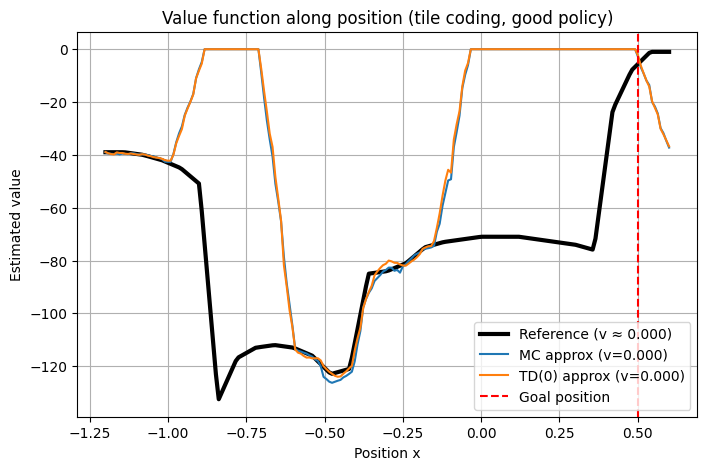

In [13]:
# ----- Plot the value function along the position axis for a chosen velocity v0 -----
def plot_vs_position_tile(w_mc, w_td, phi_fn, xs_ref, vs_ref, V_ref,
                          v0=0.0, title=""):
    """
    Plots the value function along the position axis for a fixed velocity v0.

    Parameters:
    - v0: velocity at which to slice the value function. You should experiment
          with values in the range [-0.07, 0.07], which covers all velocities in Mountain Car.
    """

    # Range of x values to plot
    xs_plot = np.linspace(POS_MIN, POS_MAX, 200)

    # Find the closest velocity index in the reference grid for v0
    j = np.argmin(np.abs(vs_ref - v0))

    # Get the reference value slice at velocity closest to v0
    Vref_slice = np.interp(xs_plot, xs_ref, V_ref[:, j])

    plt.figure(figsize=(8, 5))

    # Plot reference slice
    plt.plot(xs_plot, Vref_slice,
             label=f"Reference (v ≈ {vs_ref[j]:.3f})",
             linewidth=3, color="black")

    # MC and TD(0) approximations at v0
    vals_mc = [np.dot(w_mc, phi_fn([x, v0])) for x in xs_plot]
    vals_td = [np.dot(w_td, phi_fn([x, v0])) for x in xs_plot]

    plt.plot(xs_plot, vals_mc, label=f"MC approx (v={v0:.3f})")
    plt.plot(xs_plot, vals_td, label=f"TD(0) approx (v={v0:.3f})")

    plt.axvline(0.5, color="red", linestyle="--", label="Goal position")

    plt.xlabel("Position x")
    plt.ylabel("Estimated value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# ------ Change v0 here ------
# Try different values in the range [-0.07, 0.07], e.g.:
# v0 = -0.03
# v0 = 0.0
# v0 = 0.02
v0 = 0.0   # <-- CHANGE THIS VALUE TO EXPLORE DIFFERENT VELOCITY SLICES


# Plot the chosen slice
plot_vs_position_tile(
    w_mc_tile, w_td_tile, phi_tile,
    xs_ref, vs_ref, V_ref, v0,
    title="Value function along position (tile coding, good policy)"
)



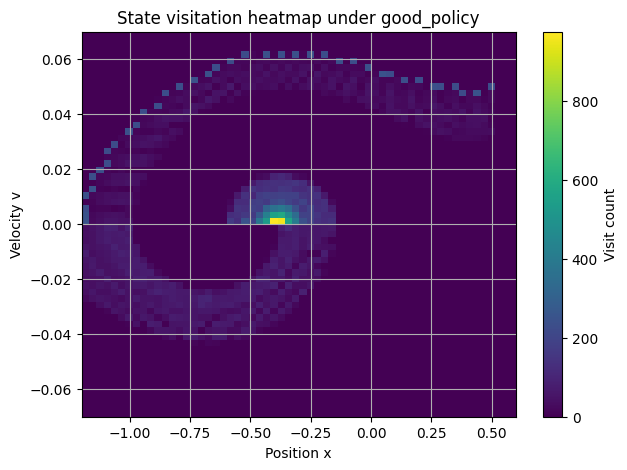

In [14]:
# === Extra diagnostics: value slices and visitation heatmap ===
import numpy as np
import matplotlib.pyplot as plt

# Visitation heatmap: where does the policy actually go in (x, v)?
def collect_visits(env, policy, num_episodes=500, max_steps=200):
    xs, vs = [], []
    for _ in range(num_episodes):
        s, info = env.reset()
        done = False
        steps = 0
        while not done and steps < max_steps:
            xs.append(s[0])
            vs.append(s[1])
            a = policy(s)
            s, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated
            steps += 1
    return np.array(xs), np.array(vs)

xs_vis, vs_vis = collect_visits(env, good_policy, num_episodes=500)

# Bin visits into a grid for heatmap
num_bins_x = 60
num_bins_v = 60
H, xedges, vedges = np.histogram2d(xs_vis, vs_vis,
                                   bins=[num_bins_x, num_bins_v],
                                   range=[[POS_MIN, POS_MAX],
                                          [VEL_MIN, VEL_MAX]])

plt.figure(figsize=(7, 5))
extent = [xedges[0], xedges[-1], vedges[0], vedges[-1]]
plt.imshow(H.T, origin="lower", extent=extent, aspect="auto")
plt.colorbar(label="Visit count")
plt.xlabel("Position x")
plt.ylabel("Velocity v")
plt.title("State visitation heatmap under good_policy")
plt.show()


## Part 4: Control with Sarsa and Tile Coding

In this part we switch from policy evaluation to **control**, using Sarsa(0) with
tile-coded action–value features to learn a policy that solves Mountain Car.

There are **two code cells**:

1. **Sarsa(0) Training + Learning Curve** — trains the agent with tile coding and plots the
   number of steps per episode (and a moving average) to show learning progress.

2. **Video of Learned Policy** — runs the greedy policy after training and records a short
   video so you can observe how the agent improves over time.

Run both cells and compare the learned behaviour to the policies from earlier parts.


Episode 500/8000, steps = 149, return = -149.0
Episode 1000/8000, steps = 117, return = -117.0
Episode 1500/8000, steps = 115, return = -115.0
Episode 2000/8000, steps = 157, return = -157.0
Episode 2500/8000, steps = 177, return = -177.0
Episode 3000/8000, steps = 122, return = -122.0
Episode 3500/8000, steps = 124, return = -124.0
Episode 4000/8000, steps = 184, return = -184.0
Episode 4500/8000, steps = 152, return = -152.0
Episode 5000/8000, steps = 167, return = -167.0
Episode 5500/8000, steps = 115, return = -115.0
Episode 6000/8000, steps = 164, return = -164.0
Episode 6500/8000, steps = 173, return = -173.0
Episode 7000/8000, steps = 145, return = -145.0
Episode 7500/8000, steps = 107, return = -107.0
Episode 8000/8000, steps = 107, return = -107.0


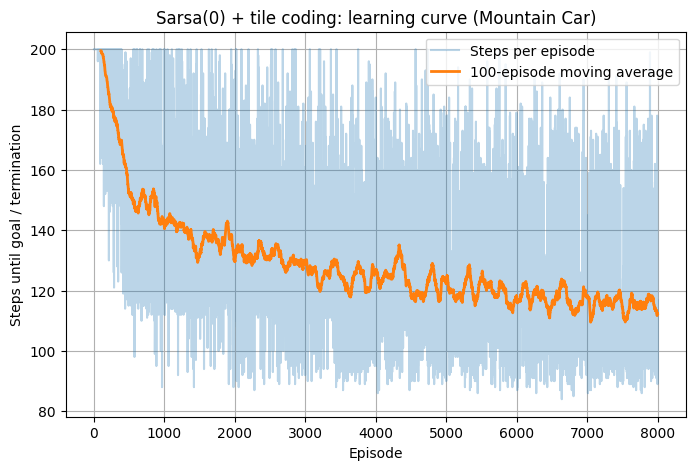

In [10]:
# === Part 4: Sarsa(0) control with tile coding (self-contained) ===
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

# -------------------------------------------------------------------
# ENVIRONMENT SETUP
# -------------------------------------------------------------------
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n  # 3 actions

POS_MIN, POS_MAX = env.observation_space.low[0], env.observation_space.high[0]
VEL_MIN, VEL_MAX = env.observation_space.low[1], env.observation_space.high[1]

# -------------------------------------------------------------------
# TILE CODING PARAMETERS (ADJUST HERE)
# -------------------------------------------------------------------
# Trade-offs:
# - More tilings / more tiles per dimension -> better approximation, but:
#     * more features, more memory
#     * slower updates (more computation per step)
#     * usually needs more episodes to converge well.
# - Fewer tilings / fewer tiles -> faster but coarser approximation.

N_TILINGS = 8      # e.g. 8 or 16
TILES_POS = 12     # number of tiles along position axis (e.g. 8–16)
TILES_VEL = 12     # number of tiles along velocity axis (e.g. 8–16)

TILES_PER_TILING = TILES_POS * TILES_VEL
FEATURE_DIM = N_TILINGS * TILES_PER_TILING

# Small offsets to shift each tiling (for better generalization)
offsets = np.linspace(0.0, 1.0, N_TILINGS, endpoint=False)

def normalize01(state):
    """Normalize (x, v) to the range [0, 1] x [0, 1]."""
    x, v = state
    x01 = (x - POS_MIN) / (POS_MAX - POS_MIN)
    v01 = (v - VEL_MIN) / (VEL_MAX - VEL_MIN)
    # clamp for numerical safety
    x01 = min(max(x01, 0.0), 0.999999)
    v01 = min(max(v01, 0.0), 0.999999)
    return x01, v01

def phi_tile(state):
    """
    Tile-coded features for a state:
    - N_TILINGS overlapping grids
    - One active tile per tiling -> N_TILINGS active features in total.
    """
    x01, v01 = normalize01(state)
    features = np.zeros(FEATURE_DIM, dtype=float)

    for tiling in range(N_TILINGS):
        # Shift and wrap into [0, 1)
        x_shifted = (x01 + offsets[tiling] / TILES_POS) % 1.0
        v_shifted = (v01 + offsets[tiling] / TILES_VEL) % 1.0

        i_pos = int(x_shifted * TILES_POS)
        i_vel = int(v_shifted * TILES_VEL)

        # Safety clamp
        i_pos = min(i_pos, TILES_POS - 1)
        i_vel = min(i_vel, TILES_VEL - 1)

        tile_index = i_pos * TILES_VEL + i_vel
        feat_index = tiling * TILES_PER_TILING + tile_index
        features[feat_index] = 1.0

    return features

# -------------------------------------------------------------------
# SARSA / LEARNING PARAMETERS (ADJUST HERE)
# -------------------------------------------------------------------
# Number of training episodes:
#   fewer  -> faster but typically worse policy,
#   more   -> slower but typically better policy.
SARSA_NUM_EPISODES = 8000

# Step size:
#   alpha ≈ ALPHA_PER_TILING / N_TILINGS is a common heuristic.
#   larger -> faster learning but more unstable,
#   smaller -> slower but more stable.
ALPHA_PER_TILING = 0.3           # effective alpha = ALPHA_PER_TILING / N_TILINGS

# Discount factor (keep at 1.0 for Mountain Car)
SARSA_GAMMA = 1.0

# Exploration schedule (epsilon-greedy):
#   EPS_START: initial exploration rate (higher -> more exploration early).
#   EPS_END:   minimum exploration rate.
#   EPS_DECAY_RATE: how fast epsilon decays (larger -> slower decay).
EPS_START = 0.2
EPS_END = 0.01
EPS_DECAY_RATE = 4000

# Moving-average window for the learning curve:
#   larger -> smoother curve, but slower to reflect changes.
MOVING_AVG_WINDOW = 100
# -------------------------------------------------------------------

# ----- Action-value features: tile coding for (state, action) -----
def phi_tile_sa(state, action):
    """
    Tile-coded features for a state-action pair.
    We allocate one block of FEATURES per action, and use the tile-coded
    state features in the block corresponding to the given action.
    """
    z = phi_tile(state)  # length FEATURE_DIM
    features = np.zeros(FEATURE_DIM * n_actions, dtype=float)
    start = action * FEATURE_DIM
    features[start:start + FEATURE_DIM] = z
    return features

def q_hat(state, action, w):
    return np.dot(w, phi_tile_sa(state, action))

# ----- Epsilon-greedy policy -----
def epsilon_greedy_action(state, w, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    qs = [q_hat(state, a, w) for a in range(n_actions)]
    return int(np.argmax(qs))

# ----- Sarsa(0) control with tile coding -----
def sarsa_control(env, num_episodes, alpha, gamma,
                  eps_start, eps_end, decay_rate):
    """
    Semi-gradient Sarsa(0) with tile-coded action-value features.

    Parameters:
    - num_episodes: number of training episodes.
    - alpha: step size.
    - gamma: discount factor.
    - eps_start, eps_end, decay_rate: parameters for epsilon decay.

    Returns:
    - w: learned weight vector
    - returns: episode returns (sum of rewards)
    - steps: number of steps in each episode
    """
    d = FEATURE_DIM * n_actions
    w = np.zeros(d, dtype=float)

    returns = []
    steps_list = []

    for ep in range(num_episodes):
        # Exponential epsilon decay
        epsilon = eps_end + (eps_start - eps_end) * np.exp(-ep / decay_rate)

        state, info = env.reset()
        action = epsilon_greedy_action(state, w, epsilon)

        done = False
        G = 0.0
        steps = 0

        while not done:
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            G += reward
            steps += 1

            if done:
                target = reward
                delta = target - q_hat(state, action, w)
                w += alpha * delta * phi_tile_sa(state, action)
            else:
                next_action = epsilon_greedy_action(next_state, w, epsilon)
                target = reward + gamma * q_hat(next_state, next_action, w)
                delta = target - q_hat(state, action, w)
                w += alpha * delta * phi_tile_sa(state, action)
                state, action = next_state, next_action

        returns.append(G)
        steps_list.append(steps)

        if (ep + 1) % 500 == 0:
            print(f"Episode {ep+1}/{num_episodes}, steps = {steps}, return = {G:.1f}")

    return w, np.array(returns), np.array(steps_list)

# ----- Run Sarsa(0) and plot learning curve -----
alpha_sarsa = ALPHA_PER_TILING / N_TILINGS  # actual alpha used

w_sarsa, ep_returns, ep_steps = sarsa_control(
    env,
    num_episodes=SARSA_NUM_EPISODES,
    alpha=alpha_sarsa,
    gamma=SARSA_GAMMA,
    eps_start=EPS_START,
    eps_end=EPS_END,
    decay_rate=EPS_DECAY_RATE
)

# Plot steps per episode and moving average
window = MOVING_AVG_WINDOW
ma_steps = np.convolve(ep_steps, np.ones(window) / window, mode="valid")

plt.figure(figsize=(8, 5))
plt.plot(ep_steps, alpha=0.3, label="Steps per episode")
plt.plot(np.arange(window - 1, SARSA_NUM_EPISODES), ma_steps,
         label=f"{window}-episode moving average", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Steps until goal / termination")
plt.title("Sarsa(0) + tile coding: learning curve (Mountain Car)")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# === Part 4: Visualizing the learned Sarsa policy (video) ===
!pip install imageio --quiet

import imageio
from IPython.display import Video
import gymnasium as gym

env_video = gym.make("MountainCar-v0", render_mode="rgb_array")

def greedy_action(state, w):
    qs = [q_hat(state, a, w) for a in range(n_actions)]
    return int(np.argmax(qs))

def record_sarsa_policy(env, w, max_steps=200, filename="sarsa_mountaincar.mp4"):
    frames = []
    state, info = env.reset()
    done = False
    steps = 0

    while not done and steps < max_steps:
        frame = env.render()
        frames.append(frame)

        action = greedy_action(state, w)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        steps += 1

    imageio.mimsave(filename, frames, fps=30)
    return filename

video_path = record_sarsa_policy(env_video, w_sarsa)
Video(video_path, embed=True)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
